In [3]:
# Training a Softmax Linear Classifier
# http://cs231n.github.io/neural-networks-case-study/
# we’ll walk through a complete implementation of a toy Neural Network in 2 dimensions. 
# We’ll first implement a simple linear classifier and then extend the code to a 2-layer Neural Network.

# hyperparameters
step_size = 1e-0
reg = 1e-3 # regularization strength


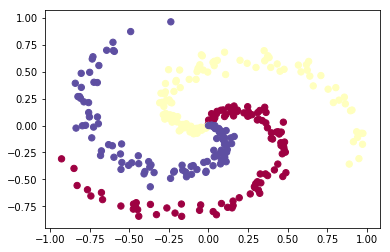

In [4]:
# Generating some data
# There are 2 attributes (x,y position)  The class variable has 3 values.  There are 100 samples.

import numpy as np
import matplotlib.pyplot as plt

N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels

for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()


In [7]:
# SCORE FUNCTION - LINEAR   x * W + b
# The score function (single sample) is  1x2 * 2x3 + 1x3 -->   1x3
# for 300 samples it is                300x2 * 2x3 + 1x3 --> 300x3
# 
# initialize parameters randomly
W = 0.01 * np.random.randn(D,K)
b = np.zeros((1,K))
print(X.shape)
print(W.shape)
print(b.shape)

(300, 2)
(2, 3)
(1, 3)


In [8]:
# Compute the class scores
# compute class scores for a linear classifier
# here they are computing *all* the scores.... 
#       300x2 * 2x3 -->  300x3 + 1x3(broadcasted) --> 300x3
scores = np.dot(X, W) + b
print(scores.shape)

(300, 3)


In [9]:
# Compute the loss
# in this example we use the cross-entropy loss that is associated with the Softmax classifier. 
#     Li = -log(e^f(yi) / sumj(e^f(yj)))
# the Softmax classifier interprets every element of f as holding the (unnormalized) log probabilities
# of the three classes. We exponentiate these to get (unnormalized) probabilities, and then normalize
# them to get probabilites. Therefore, the expression inside the log is the normalized probability of the correct class.
#
# the full Softmax classifier loss is then defined as the average cross-entropy loss over the training examples
# and the regularization:
#    L = 1/N sumi(Li)              + 1/2 lambda     sumk(suml(Wkl^2))
#        (avg element-wise loss)         (weighted W2 regularization)
num_examples = X.shape[0]
# get unnormalized probabilities
exp_scores = np.exp(scores)
# normalize them for each example
probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
print(probs.shape)

# We now have an array probs of size [300 x 3], where each row now contains the class probabilities. In particular, since we’ve normalized them every row now sums to one. We can now query for the log probabilities assigned to the correct classes in each example:
corect_logprobs = -np.log(probs[range(num_examples),y])

# The array correct_logprobs is a 1D array of just the probabilities assigned to the correct classes for each example.
# The full loss is then the average of these log probabilities and the regularization loss:
# compute the loss: average cross-entropy loss and regularization
data_loss = np.sum(corect_logprobs)/num_examples
reg_loss = 0.5*reg*np.sum(W*W)
loss = data_loss + reg_loss

# In this code, the regularization strength λλ is stored inside the reg. The convenience factor of 0.5 multiplying the regularization will become clear in a second. Evaluating this in the beginning (with random parameters) might give us loss = 1.1, which is np.log(1.0/3), since with small initial random weights all probabilities assigned to all classes are about one third. We now want to make the loss as low as possible, with loss = 0 as the absolute lower bound. But the lower the loss is, the higher are the probabilities assigned to the correct classes for all examples.
print(loss)



(300, 3)
1.09593201239


In [10]:
# Computing the Analytic Gradient with Backpropagation
# (refer to the Stanford notes here... )
# dLi / dfk = pk - 1 (if yi = k)
#           = pk (if yi != k)

dscores = probs
dscores[range(num_examples),y] -= 1
dscores /= num_examples

# armed with the gradient on scores (stored in dscores), we can now backpropagate into W and b:
dW = np.dot(X.T, dscores)
db = np.sum(dscores, axis=0, keepdims=True)
dW += reg*W # don't forget the regularization gradient



In [11]:
# Performing a parameter update
# Now that we’ve evaluated the gradient we know how every parameter
# influences the loss function. We will now perform a parameter update
# in the negative gradient direction to decrease the loss:

# perform a parameter update
W += -step_size * dW
b += -step_size * db

In [12]:
# Putting it all together: Training a Softmax Classifier
#Train a Linear Classifier

# initialize parameters randomly
W = 0.01 * np.random.randn(D,K)
b = np.zeros((1,K))

# some hyperparameters
step_size = 1e-0
reg = 1e-3 # regularization strength

# gradient descent loop
num_examples = X.shape[0]
for i in range(200):
  
  # evaluate class scores, [N x K]
  scores = np.dot(X, W) + b 
  
  # compute the class probabilities
  exp_scores = np.exp(scores)
  probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]
  
  # compute the loss: average cross-entropy loss and regularization
  corect_logprobs = -np.log(probs[range(num_examples),y])
  data_loss = np.sum(corect_logprobs)/num_examples
  reg_loss = 0.5*reg*np.sum(W*W)
  loss = data_loss + reg_loss
  if i % 10 == 0:
    print("iteration %d: loss %f" % (i, loss))
  
  # compute the gradient on scores
  dscores = probs
  dscores[range(num_examples),y] -= 1
  dscores /= num_examples
  
  # backpropate the gradient to the parameters (W,b)
  dW = np.dot(X.T, dscores)
  db = np.sum(dscores, axis=0, keepdims=True)
  
  dW += reg*W # regularization gradient
  
  # perform a parameter update
  W += -step_size * dW
  b += -step_size * db

# evaluate training set accuracy
scores = np.dot(X, W) + b
predicted_class = np.argmax(scores, axis=1)
print('training accuracy: %.2f' % (np.mean(predicted_class == y)))

iteration 0: loss 1.101010
iteration 10: loss 0.901932
iteration 20: loss 0.828439
iteration 30: loss 0.795266
iteration 40: loss 0.778078
iteration 50: loss 0.768327
iteration 60: loss 0.762439
iteration 70: loss 0.758723
iteration 80: loss 0.756298
iteration 90: loss 0.754674
iteration 100: loss 0.753566
iteration 110: loss 0.752797
iteration 120: loss 0.752257
iteration 130: loss 0.751873
iteration 140: loss 0.751598
iteration 150: loss 0.751400
iteration 160: loss 0.751256
iteration 170: loss 0.751151
iteration 180: loss 0.751074
iteration 190: loss 0.751018
training accuracy: 0.52


In [13]:
# Training a Neural Network
# Clearly, a linear classifier is inadequate for this dataset and we would like
# to use a Neural Network. One additional hidden layer will suffice for this toy data.
# We will now need two sets of weights and biases (for the first and second layers):

# initialize parameters randomly
h = 100 # size of hidden layer
W = 0.01 * np.random.randn(D,h)
b = np.zeros((1,h))
W2 = 0.01 * np.random.randn(h,K)
b2 = np.zeros((1,K))

# some hyperparameters
step_size = 1e-0
reg = 1e-3 # regularization strength

# gradient descent loop
num_examples = X.shape[0]
for i in range(10000):
  
  # evaluate class scores, [N x K]
  hidden_layer = np.maximum(0, np.dot(X, W) + b) # note, ReLU activation
  scores = np.dot(hidden_layer, W2) + b2
  
  # compute the class probabilities
  exp_scores = np.exp(scores)
  probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]
  
  # compute the loss: average cross-entropy loss and regularization
  corect_logprobs = -np.log(probs[range(num_examples),y])
  data_loss = np.sum(corect_logprobs)/num_examples
  reg_loss = 0.5*reg*np.sum(W*W) + 0.5*reg*np.sum(W2*W2)
  loss = data_loss + reg_loss
  if i % 1000 == 0:
    print("iteration %d: loss %f" % (i, loss))
  
  # compute the gradient on scores
  dscores = probs
  dscores[range(num_examples),y] -= 1
  dscores /= num_examples
  
  # backpropate the gradient to the parameters
  # first backprop into parameters W2 and b2
  dW2 = np.dot(hidden_layer.T, dscores)
  db2 = np.sum(dscores, axis=0, keepdims=True)
  # next backprop into hidden layer
  dhidden = np.dot(dscores, W2.T)
  # backprop the ReLU non-linearity
  dhidden[hidden_layer <= 0] = 0
  # finally into W,b
  dW = np.dot(X.T, dhidden)
  db = np.sum(dhidden, axis=0, keepdims=True)
  
  # add regularization gradient contribution
  dW2 += reg * W2
  dW += reg * W
  
  # perform a parameter update
  W += -step_size * dW
  b += -step_size * db
  W2 += -step_size * dW2
  b2 += -step_size * db2

# evaluate training set accuracy
hidden_layer = np.maximum(0, np.dot(X, W) + b)
scores = np.dot(hidden_layer, W2) + b2
predicted_class = np.argmax(scores, axis=1)
print('training accuracy: %.2f' % (np.mean(predicted_class == y)))

    

iteration 0: loss 1.098625
iteration 1000: loss 0.306099
iteration 2000: loss 0.254515
iteration 3000: loss 0.243938
iteration 4000: loss 0.241798
iteration 5000: loss 0.241296
iteration 6000: loss 0.241063
iteration 7000: loss 0.240899
iteration 8000: loss 0.240789
iteration 9000: loss 0.240719
training accuracy: 0.99
